# Visual Explanations for Handwriting Verification using Grad-CAM

This notebook is a demo for *Handwriting Verification*, where is the goal is to find whether the given two samples are from same writers or different writers [intra-writers or inter-writers]  by evaluating the similarity between two given handwritten samples. 
Forensic community has used the Likelihood ratio [LR] to find the degree of similarity between a Known k and a Questioned q sample. However the methods previously used by the forensic analysts are purely based on handcrafted features. By using the deep learning model we are acheiveing a good performance and accuracy but the deep learning is a black box. 
So we go for the Explainable Artifical Intelligence Interface (XAI) 
* a) Textual explaination
* b) Visual explaination:
Grad-CAM, Which uses the gradient of target, flowing through the final convolution layer to produce a coarse localization layer [heatmap] highlighting the important regions in the image.


* [Grad-CAM ICCV paper]:(https://arxiv.org/pdf/1710.11063.pdf)
* [Code reference]: (https://github.com/PowerOfCreation/keras-grad-cam/blob/master/grad-cam.py)
* [Dataset]:  (https://)
* [Blog Reference]: (https://machinelearningfromub.home.blog/)



<img src=" https://docs.google.com/uc?export=download&id=1kD6DGpZsfLXANZOQon811StrChThff5F" alt="Grad-CAM heatmap" width="300" height = "300"  align="middle">


## 1: Environment Setup


This notebook sythesis of the images of word "and" which are cropped from a letter written by different writters. Where the images are loaded into google colab drive and trained on CNN model.
* This environment consists of the following sections:
    *  Pre-processing of Dataset.
    *  GradCAM function
    *  Model






### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Then press the **Play** button on the left of each of the cells
* Double-click any of the cells to view the code


In [4]:
#@title Libraries
#@markdown import essential libraries.

from google.colab import files
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.models import Model
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras import optimizers,activations
import sys
import cv2
from keras.layers import Input, Conv2D,Flatten,Dense,MaxPooling2D
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
#@title ## 1.2: Reading Dataset
#@markdown About Dataset:
#@markdown XAI-AND dataset is a publicly available dataset for handwriting verification, comprising of 15,518 “AND” image fragments extracted from CEDAR Letter Dataset \cite{Individuality:1} written by 1567 writers. Each ``AND'' image fragment is labeled by a questioned document (QD) examiner with 15 explainable discrete features. QD examiners have specified these handwriting features based on years of training using seven fundamental elements of handwriting as shown below. We have created a web based truthing tool for QD examiners to enter the values for the 15 features for “AND” images fragments. The data entry work using the truthing tool was shared primarily between 89 external examiners. The data entered by the external examiners was verified by 2 QD examiners. The resultant dataset serves as a good resource for explanation based handwriting verification.
#@markdown Here we are cloning the Dataset from the Github Repository and splitting the whole data set into training and validation set.

! git clone https://github.com/kumarankit1996/Dataset.git

#@markdown 
def image_dataset(data):
  Train_dataset={}
  Val_dataset={}
  #getting inside directory
  imgs=os.listdir("Dataset/AML_Proj2/"+data+"/TrainingSet/")
  #looping over all the images in the directory
  for name in imgs:
    img=cv2.imread("Dataset/AML_Proj2/"+data+"/TrainingSet/"+str(name),0)
    if img is not None:
      img=(255.0-img)/255.0
      Train_dataset[name]=img
  imgs=os.listdir("Dataset/AML_Proj2/"+data+"/ValidationSet/")
  #looping over all the images in the directory
  for name in imgs:
    img=cv2.imread("Dataset/AML_Proj2/"+data+"/ValidationSet/"+str(name),0)
    if img is not None:
      img=(255.0-img)/255.0
      Val_dataset[name]=img
  return Train_dataset,Val_dataset


input_shape=(64,64)
classes=4
#@markdown
#Train_seen_images,Val_seen_images=image_dataset("seen-dataset")
Train_unseen_images,Val_unseen_images=image_dataset("unseen-dataset")
#Train_shuffled_images,Val_shuffled_images=image_dataset("shuffled-dataset")

#@markdown
all_feature=pd.read_csv("Dataset/AML_Proj2/15features.csv")
all_feature.set_index('imagename',inplace=True)

Cloning into 'Dataset'...
remote: Enumerating objects: 14198, done.
remote: Total 14198 (delta 0), reused 0 (delta 0), pack-reused 14198
Receiving objects: 100% (14198/14198), 197.53 MiB | 34.57 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (42293/42293), done.


In [6]:
#@title ## 1.3: Functions 
#@markdown ###  1.3.1: Datagen
#@markdown Datagen Exlaination
def datagen(s,batch_size,hshift=(-64,64),val=False):
  w=h=64
  global writer_info
  if s=='seen_train':
    #X=Train_seen_data
    dataset=list(Train_seen_images.items())
  elif s=="seen_val":
    #X=Val_seen_data
    dataset=list(Val_seen_images.items())  
  elif s=="unseen_train":
    #X=Train_unseen_data
    dataset=list(Train_unseen_images.items())
  elif s=="unseen_val":
    #X=Val_unseen_data
    dataset=list(Val_unseen_images.items())
  elif s=="shuffled_train":
    #X=Train_shuffled_data
    dataset=list(Train_shuffled_images.items())
  elif s=="shuffled_val":
    #X=Val_shuffled_data
    dataset=list(Val_shuffled_images.items())
  while True:
    # counter for number of images in a batch
    counter=0
    # train x
    x=[]
    # target
    y=[]
    # writers name list
    writers=[]
    # writer ids
    ids=[]
    index=np.random.randint(0,len(dataset),batch_size)
    try:
      for i in index:
        # adding writers  name
        writers.append(dataset[i][0])
        #extract target
        target=all_feature.loc[dataset[i][0],'staff_of_a']
        y.append(to_categorical(target-1,num_classes=classes))
        # appending the orignal images
        x.append(dataset[i][1].reshape((64,64,1)))
        # adding the writer id
        ids.append(dataset[i][0][:4])
        if val==True:
          writer_info.append([dataset[i][0][:4],dataset[i][0]])
        counter+=1
    except:
      continue
    if counter<=batch_size:
      if val==True:
        yield np.array(x),np.array(y)
      else:
        yield np.array(x),np.array(y)
        
        
        
        
#@markdown ### 1.3.2: GradCAM function
#@markdown The GradCAM is the visualization technique used to visually explain the decisions from the large class of Convolution neural network (CNN), -based models.In this method, The output predicted class is decoded and the gradients are calculated with respect to the output layer of the model. By performing the global average pooling technique [i.e; taking the mean of grad values] we can calculate the new important weights of part of an image which was predicted by our model.We make the mask which is generally a blur effect on the image.This mask is superimposed on the image which was given to model to predict, to highlight only the predicted part and remaining part of the image is blurred.

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(img):
    #img_path = sys.argv[1]
    #img = image.load_img(path, target_size=input_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv5'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def grad_cam(input_model, image, category_index, layer_name):
    #number of classes
    nb_classes = classes
    #target layer convertion into one hot and category wise activation
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    # Lamda layer added to the model with output shape =input shape
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=x)
    #model.summary()
    # loss= sum of the output of all the output/last layer nodes and input layer
    loss = K.sum(model.output)
    # conv output is output of the conv layer and also checked for the name of the 5th layer
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output
    # gradient calculated and also normalised between the output and the the last conv layer
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    # a instance of the input layer and the last conv layer created 
    gradient_function = K.function([model.input], [conv_output, grads])
    
    # the image is passed in the instance and the output image with its gradient w.r.t to last conv layer is extracted
    output, grads_val = gradient_function([image])
    #print(grads_val.shape)
    #print(output.shape)
    
    # output of the gradient function and its gradient value
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    print(grads_val.shape)
    print(output.shape)
    
    # weights is calculated = mean of each channel
    weights = np.mean(grads_val, axis = (0, 1))
    #print(weights.shape)
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    
    # channel wise multiplication with each weights
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
        #print(output[:,:,i].shape)
        
    #print(cam.shape)
    cam = cv2.resize(cam, (input_shape))
    print(cam.shape)
    cam = np.maximum(cam, 0)
    # normalizing the cam with max value to extract important heatmap
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap
print('execution done')

execution done


##  2:  Model
<img src=" https://docs.google.com/uc?export=download&id=1KS6MkrLy9NGl66rVP8uYwyejPYvqNVLo" alt="Grad-CAM heatmap" width="600" height = "400">


In [7]:
#@title #  2.1: Defining the Model
#@markdown The model as 5 convolution layers, where each convolution layer is followed by a Max-pool operation. Furthermore, each convolution layer has a kernel of dimension (3x3) and each Max-pooling has a pool size of (2x2). Then the output of the last convolution layer is flattened using a flatten layer, where we get 2096 features. Next, the flatten layer is connected to two fully connected layers [FC]. At the last, a softmax layer was applied to detect the classes of the 15 features. Using this whole architecture the model was trained and we have got the best weights was stored. Using this trained model the individual class probabilities of each feature were obtained and argmax was applied to predict the class. The predicted class was passed on to GradCAM as class activation index. 




img_input=Input(shape=(64,64,1))
x= Sequential()
x=Conv2D(64, (3, 3),activation='relu',padding='same',name='conv1')(img_input)
x=MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)
x=Conv2D(128,(3,3),activation='relu',padding='same',name='conv2')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)
x=Conv2D(256,(3,3),activation='relu',padding='same',name='conv3')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)
x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv4')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
x=Conv2D(512,(3,3),activation='relu',padding='same',name='conv5')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x=Flatten(name='flatten')(x)
x=Dense(4096,activation='relu',name='fc1')(x)
x=Dense(4096,activation='relu',name='fc2')(x)
x=Dense(classes,activation='softmax',name='prediction')(x)

model=Model(img_input,x)
model.compile(optimizer=optimizers.Adadelta(lr=0.01), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 256)       295168    
_________________________________________________________________
pool

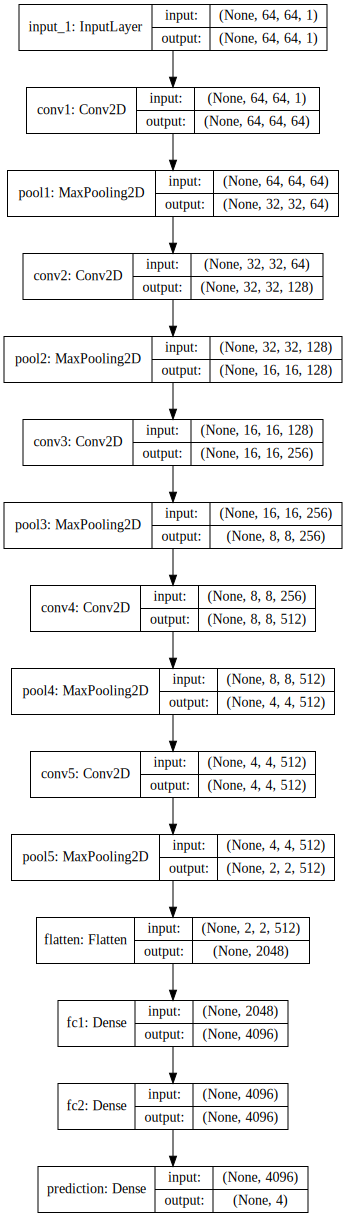

In [8]:
#@title # 2.2: Creating the model Checkpoint and adding the earrly-stopping.
# GradCam_unseen_weights_v16_decay.h5
#@markdown enter the filename for saving the weights.
file_name = 'GradCam_unseen_weights_v200_decay.h5' #@param {type:"string"}
early_stopping = 2000   #@param {type:"number"}
mc = ModelCheckpoint(filepath=file_name, monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto', verbose = 3)
es = EarlyStopping(patience=early_stopping, monitor='val_loss', min_delta=0.0005, mode='auto')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))# SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#@title # 2.3: Train the model
#@
batch_size=64 #@param {type:"number"}
epoch=200    #@param {type: "number"}
tsteps=len(Train_unseen_images)/batch_size
vsteps=len(Val_unseen_images)/batch_size
model.fit_generator(datagen("unseen_train",batch_size),callbacks=[mc,es],epochs=epoch,steps_per_epoch=1,validation_data=datagen("unseen_val",batch_size),validation_steps=1)

In [0]:
#@markdown Download the weights
files.download(file_name)
print('--Download Completed--')

## 3:  Predict the Output class and calculate the coarse Localization MAP [Heatmap]

In [19]:
#@title
#@markdown We are testing the trained model by giving all Handwriting sample in the testing set and caluclating the heatmap for the predicted class.
preprocessed_input = load_image(cv2.imread("Dataset/AML_Proj2/unseen-dataset/ValidationSet/1451a_num1.png",0))
print(preprocessed_input.shape)
ld_weights = "file_name" #@param ["GradCam_seen_weights_v3.h5", "file_name"] 

model.load_weights(ld_weights)
predictions = model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
print(predicted_class)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv5")
cv2.imwrite("gradcam.jpg",cam)

(1, 64, 64, 1)
0
(4, 4, 512)
(4, 4, 512)
(64, 64)


True

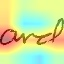

In [20]:
#@title ### 3.1: Save and display the predicted image 
y=cv2.imread("gradcam.jpg")
from google.colab.patches import cv2_imshow
cv2_imshow(y)